# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

## Study on simple random sinusoidal images vs. real valued bent functions (maximaly non-linear) images

### Simple sinusoidal images:
Generate sinusoidal data with random phase and frequency:

$$Z = \sin(2\pi f_x x + \phi_x) \cos(2\pi f_y y + \phi_y)$$

Where:
- $f_x$ is the frequency multiplier for x
- $f_y$ is the frequency multiplier for y
- $\phi_x$ is the phase shift for x
- $\phi_y$ is the phase shift for y

### Real valued Bent functions:

$$Z = \cos(2\pi(aX + bY)) + \cos(2\pi(cX - dY))$$

Where $a$, $b$, $c$, and $d$ are parameters controlling the function's behavior.



## Imports and Initialization

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from IPython.display import display, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn

import scienceplots
plt.style.use(['science','no-latex'])

# Query the current default figure size
current_fig_size = plt.rcParams["figure.figsize"]
print(f"Current default figure size: {current_fig_size}")

# Define a scalar factor
scalar_factor = 1.5

# Multiply the current figure size by the scalar factor
new_fig_size = [size * scalar_factor for size in current_fig_size]

# Set the new default figure size
plt.rcParams["figure.figsize"] = new_fig_size

print(f"New default figure size: {new_fig_size}")
import numpy as np
import torch
from sklearn import decomposition

Current default figure size: [3.5, 2.625]
New default figure size: [5.25, 3.9375]


In [4]:
import polcanet.polcanet_reports as report
from polcanet import LinearDecoder, PolcaNet
from polcanet.example_aencoders import (
    ConvEncoder,
    LSTMEncoder,
    StandardScalerTorch,
    generate_2d_sinusoidal_data,
    generate_bent_images,
)

In [5]:
np.random.seed(5)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

In [37]:
from utils import visualise_reconstructed_images, display_metrics_table

## Synthetic Sinudosial and Bent Images

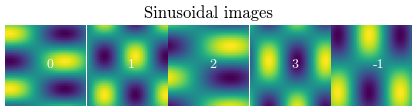

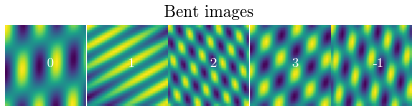

In [7]:
# Parameters
N = 32  # Sequence length
M = 32  # Number of features
num_samples = 1000

# Generate 2D sinusoidal data
data_sin = generate_2d_sinusoidal_data(N, M, num_samples)
data_sin.shape

# Generate 2D real bent function images data
data_bent = generate_bent_images(N, M, num_samples)
data_bent.shape

def plot_train_images(x, title, n=1):
    # Plot original and reconstructed signals for a sample
    fig, axes = plt.subplots(1, n + 1)
    fig.subplots_adjust(wspace=0.01)
    im_list = list(range(n)) + [-1]
    for i in im_list:
        axes[i].imshow(x[i], cmap="viridis")
        if i==n//2:
            axes[i].set_title(f"{title}")
        axes[i].axis("off")
        axes[i].text(x[i].shape[0] // 2, x[i].shape[1] // 2, str(i),color="white")

    plt.show()

plot_train_images(data_sin, "Sinusoidal images", n=4)
plot_train_images(data_bent, "Bent images", n=4)

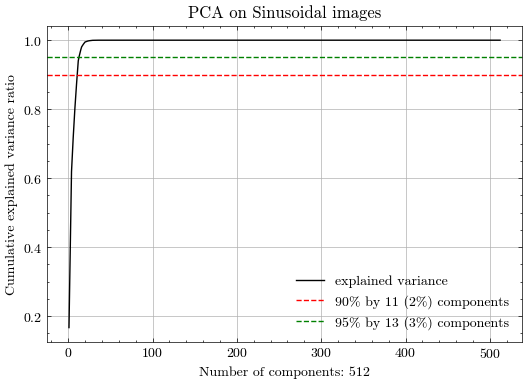

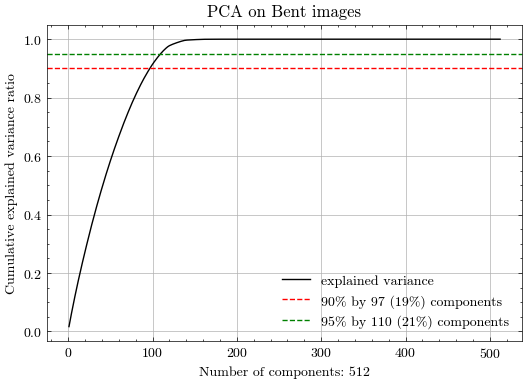

In [36]:
def get_pca(X, ax=None, title="", n_components=None):
    n_components = n_components or np.prod(X[0].shape) //2   
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(np.squeeze(X.reshape(X.shape[0], -1)))
    # Xpca = pca.transform(X.reshape(X.shape[0], -1))    
    
    # Compute cumulative explained variance ratio
    cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)
    # Print the number of components needed for 90% and 95% explained variance
    components_90 = np.argmax(cumulative_variance_ratio >= 0.9) + 1
    components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1   
    
    # If ax is not provided, create a new figure and axis
    if ax is None:
        fig, ax = plt.subplots()
    
    ax.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio,color="black",label="explained variance",lw=1)
    ax.set_xlabel(f'Number of components: {n_components}')
    ax.set_ylabel('Cumulative explained variance ratio')
    ax.set_title(title)
    ax.grid(True)
    
    # Add some reference lines
    ax.axhline(y=0.9, color='r', linestyle='--',lw=1, label=f"90% by {components_90} ({round(100*components_90/n_components)}%) components")
    ax.axhline(y=0.95, color='g', linestyle='--',lw=1, label=f"95% by {components_95} ({round(100*components_95/n_components)}%) components")
    
    ax.legend()
    ax.set_box_aspect(2/3)
    
    
    
    return pca


n_components = int((N*M)//13)
fig, axs = plt.subplots(1,1,sharex=True, sharey=True,layout='constrained')
pca_sin = get_pca(data_sin,axs,title="PCA on Sinusoidal images",n_components=n_components)
plt.show()

fig, axs = plt.subplots(1,1,sharex=True, sharey=True,layout='constrained')
pca_bent = get_pca(data_bent,axs,title="PCA on Bent images",n_components=n_components)
plt.show()

## Create the POLCA-Net

### Create a POLCA-Net with an LSTM Encoder

In [9]:
# ae_input = data
# act_fn = torch.nn.Mish()
# input_dim = ae_input[0].shape
# latent_dim = 256
# assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
# assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

# encoder_lstm = LSTMEncoder( input_dim=input_dim[1], latent_dim=latent_dim, num_layers=2)
   

# decoder_lstm = LinearDecoder(latent_dim=latent_dim, input_dim=input_dim, hidden_dim=256, num_layers=2)

# model_lstm = PolcaNet(
#     encoder=encoder_lstm,
#     decoder=decoder_lstm,
#     latent_dim=latent_dim,
#     alpha=0.1,  # ortgogonality loss
#     beta=1.0,  # variance sorting loss
#     gamma=1.0,  # variance reduction loss
#     device="cuda",
#     # scaler=StandardScalerTorch(),
# )
# model

### Create a POLCA-Net with a 2D Convolutional Encoder

#### Train on Sinusoidal Images

In [10]:
from polcanet.example_aencoders import ConvEncoder

ae_input = data_sin
act_fn = torch.nn.SiLU
input_dim = (N, M)
latent_dim = n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

# encoder_sin = ConvEncoder(
#     input_dim=input_dim[1],
#     latent_dim=latent_dim,
#     conv_dim=2,
#     act_fn=act_fn,
# )

encoder_sin = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=8,
    growth_factor=2,
    num_layers=5,
    act_fn=act_fn,
)

decoder_sin = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=1024,
    num_layers=2,
)

model_sin = PolcaNet(
    encoder=encoder_sin,
    decoder=decoder_sin,
    latent_dim=latent_dim,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    # scaler=StandardScalerTorch(),
)
print(model_sin)

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): Sequential(
      (0): ConvEncoder(
        (encoder): Sequential(
          (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): SiLU()
          (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (3): SiLU()
          (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (5): SiLU()
          (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (7): SiLU()
          (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (9): SiLU()
          (10): Flatten(start_dim=1, end_dim=-1)
          (11): Linear(in_features=128, out_features=312, bias=True)
          (12): SiLU()
          (13): Linear(in_features=312, out_features=78, bias=True)
        )
      )
      (1): Tanh()
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=78, out_features=1024, bia

In [12]:
model_sin.to("cuda")
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 4999
Total Loss: 0.001811
Reconstruction Loss: 0.000156
Orthogonality Loss: 0.005699
Center of Mass Loss: 0.0006551
Variance Distribution Loss: 0.0001101


In [13]:
model_sin.train_model(data=data_sin, batch_size=512, num_epochs=5000, report_freq=20, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 4999
Total Loss: 0.001069
Reconstruction Loss: 2.676e-05
Orthogonality Loss: 0.003408
Center of Mass Loss: 0.0004524
Variance Distribution Loss: 0.000114


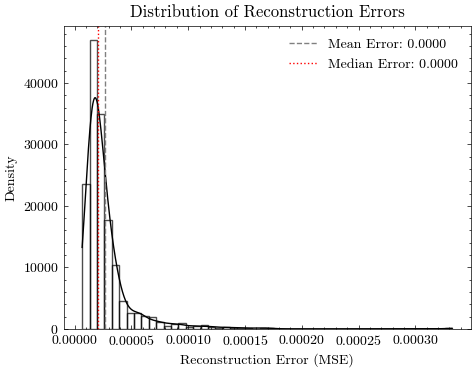

Mean Reconstruction Error: 0.0000
Median Reconstruction Error: 0.0000
Min Reconstruction Error: 0.0000
Max Reconstruction Error: 0.0003


In [15]:
report.analyze_reconstruction_error(model_sin, data_sin, n_samples=10000)

In [16]:
latents, reconstructed = model_sin.predict(data_sin)
data_sin.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 78))

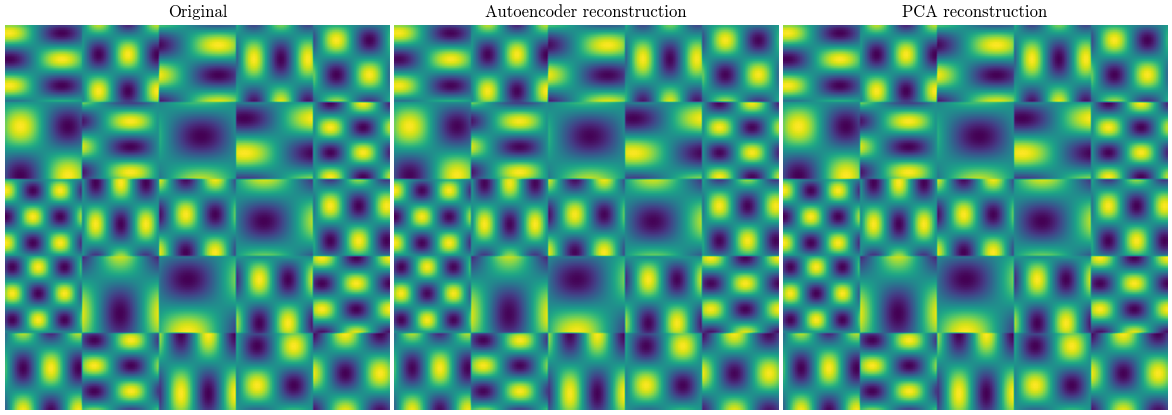

In [17]:
X_test = data_sin
# Assuming images are properly defined as before
images = X_test[0:25]

# Reconstruct and visualise the images using the autoencoder
model = model_sin
_, ae_reconstructed = model.predict(images)

# Reconstruct and visualize the imagaes by PCA
pca_latents = pca_sin.transform(images.reshape(images.shape[0], -1))
pca_reconstructed = pca_sin.inverse_transform(pca_latents)
pca_reconstructed = pca_reconstructed.reshape(images.shape[0], N, M)

visualise_reconstructed_images(
    [images, ae_reconstructed, pca_reconstructed],
    title_list=["Original", "Autoencoder reconstruction", "PCA reconstruction"],
)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0001
    - Max cosine similarity: 1.0000
    - Min cosine similarity: -1.0000
    


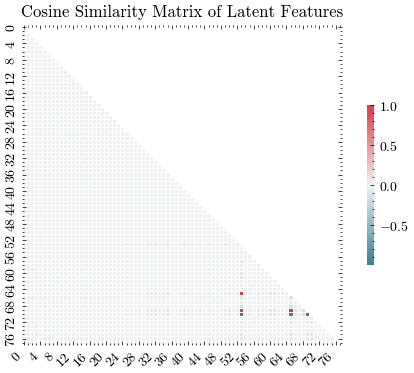

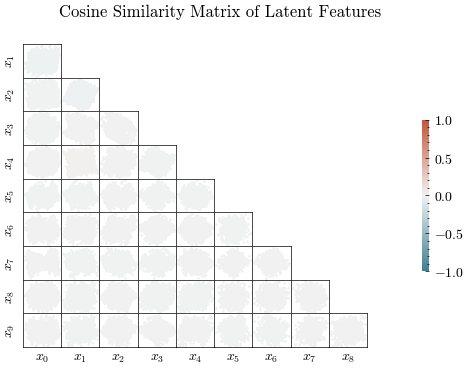

In [18]:
report.orthogonality_test_analysis(model_sin, data_sin)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.9768
    - Variance fit to exponential distribution (sum of squared differences):
     0.0474
    


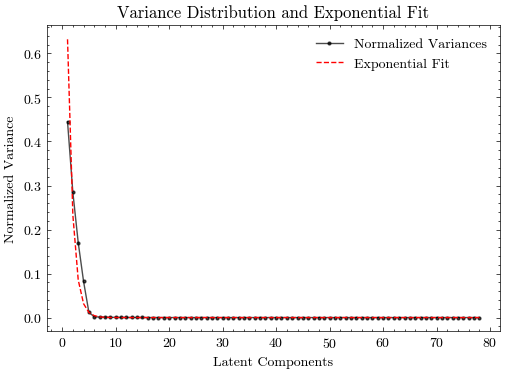

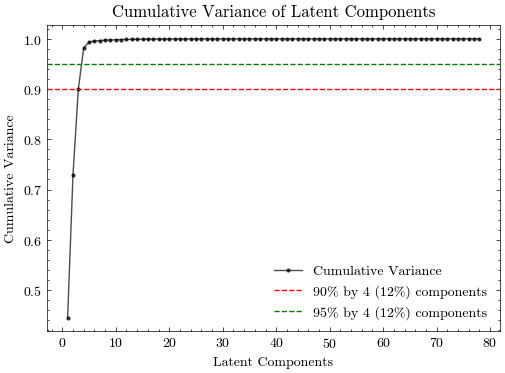

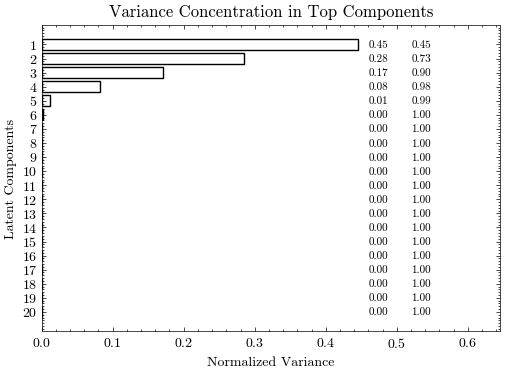

In [19]:
report.variance_test_analysis(model_sin, data_sin)

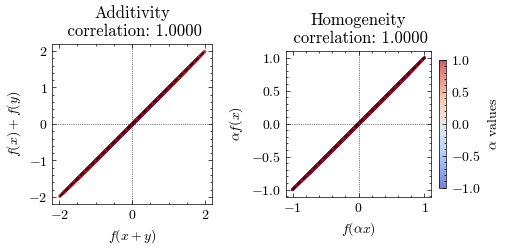

In [20]:
report.linearity_tests_analysis(model_sin, data_sin,num_samples=200)

#### Train on Bent Images

In [21]:
ae_input = data_bent
act_fn = torch.nn.SiLU
input_dim = (N,M)
latent_dim = n_components
assert N == input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M == input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_bent = ConvEncoder(
    input_channels=1,
    latent_dim=latent_dim,
    conv_dim=2,
    initial_channels=16,
    growth_factor=2,
    num_layers=6,
    act_fn=act_fn,
)

decoder_bent = LinearDecoder(
    latent_dim=latent_dim,
    input_dim=input_dim,
    hidden_dim=1024,
    num_layers=2,
)

model_bent = PolcaNet(
    encoder=encoder_bent,
    decoder=decoder_bent,
    latent_dim=latent_dim,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda",
    # scaler=StandardScalerTorch(),
)
print(model_bent)

PolcaNet(
  (encoder): EncoderWrapper(
    (encoder): Sequential(
      (0): ConvEncoder(
        (encoder): Sequential(
          (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (1): SiLU()
          (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (3): SiLU()
          (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (5): SiLU()
          (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (7): SiLU()
          (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (9): SiLU()
          (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (11): SiLU()
          (12): Flatten(start_dim=1, end_dim=-1)
          (13): Linear(in_features=512, out_features=312, bias=True)
          (14): SiLU()
          (15): Linear(in_features=312, out_features=78, bias=True)
        )
      )
      (1): Tanh()
    )
  )


In [23]:
model_bent.to("cuda")
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=10, lr=1e-3)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 4999
Total Loss: 0.01577
Reconstruction Loss: 0.0135
Orthogonality Loss: 0.003449
Center of Mass Loss: 0.001068
Variance Distribution Loss: 0.000128


In [24]:
model_bent.train_model(data=data_bent, batch_size=512, num_epochs=5000, report_freq=10, lr=1e-4)

epoch:   0%|          | 0/5000 [00:00<?, ?it/s]

Final metrics at epoch: 4999
Total Loss: 0.01461
Reconstruction Loss: 0.01298
Orthogonality Loss: 0.002956
Center of Mass Loss: 0.0007564
Variance Distribution Loss: 0.0001295


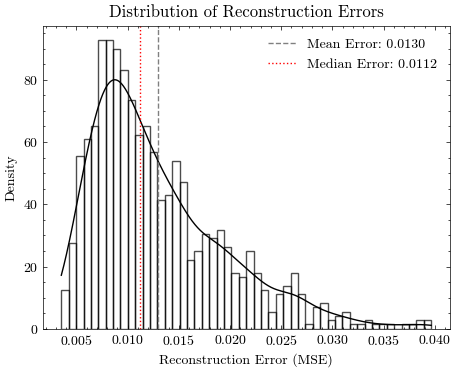

Mean Reconstruction Error: 0.0130
Median Reconstruction Error: 0.0112
Min Reconstruction Error: 0.0035
Max Reconstruction Error: 0.0396


In [25]:
report.analyze_reconstruction_error(model_bent, data_bent, n_samples=10000)

In [26]:
latents, reconstructed = model_bent.predict(data_bent)
data_bent.shape, reconstructed.shape, latents.shape

((1000, 32, 32), (1000, 32, 32), (1000, 78))

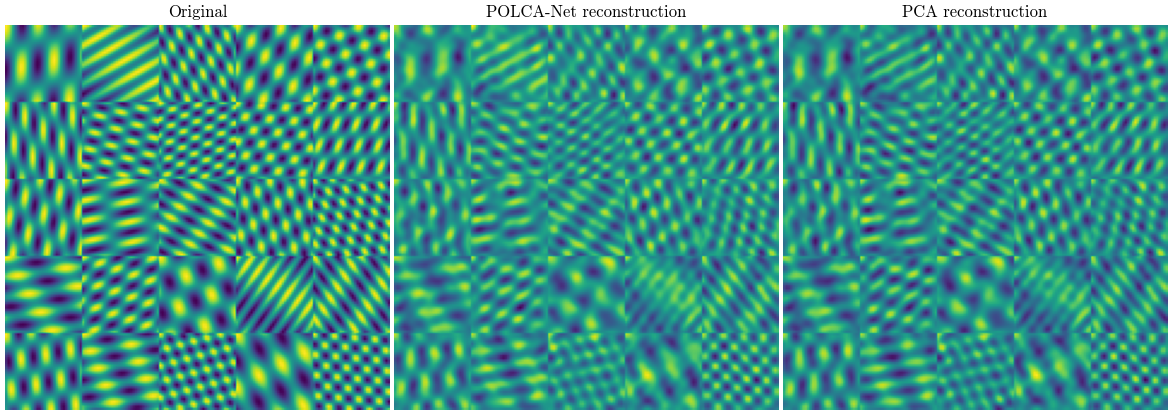

In [27]:
images = data_bent[0:25]
# Reconstruct and visualise the images using the autoencoder
model = model_bent
_, ae_reconstructed = model.predict(images)

# Reconstruct and visualize the imagaes by PCA
pca_latents = pca_bent.transform(images.reshape(images.shape[0], -1))
pca_reconstructed = pca_bent.inverse_transform(pca_latents)
pca_reconstructed = pca_reconstructed.reshape(images.shape[0], N, M)

visualise_reconstructed_images(
    [images, ae_reconstructed, pca_reconstructed],
    title_list=["Original", "POLCA-Net reconstruction", "PCA reconstruction"],
)


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0007
    - Max cosine similarity: 0.9943
    - Min cosine similarity: -0.9927
    


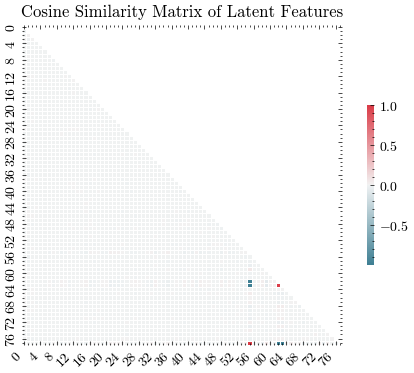

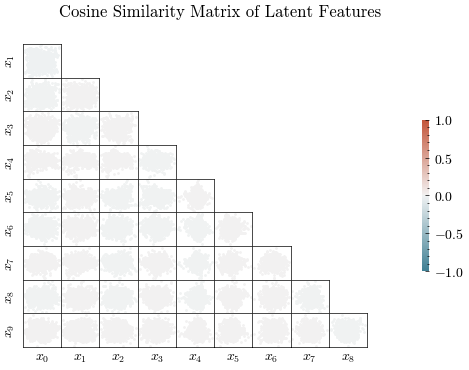

In [28]:
report.orthogonality_test_analysis(model_bent, data_bent)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.9755
    - Variance fit to exponential distribution (sum of squared differences):
     0.0454
    


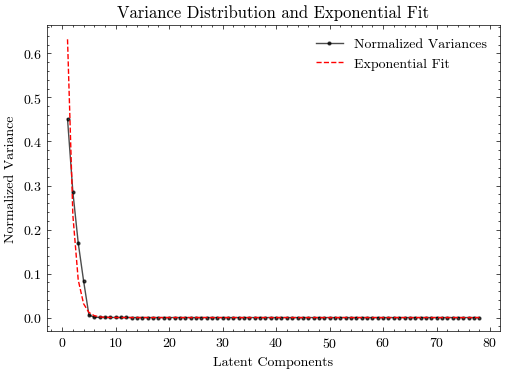

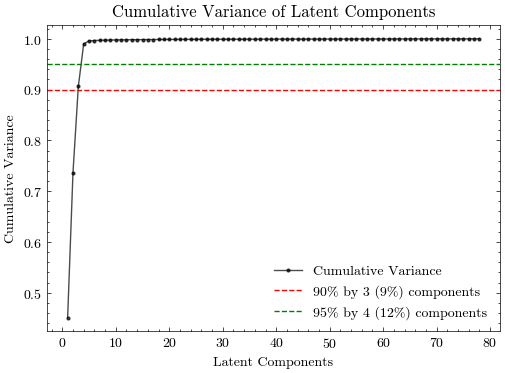

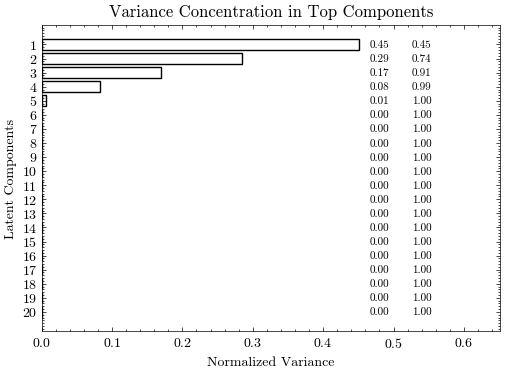

In [30]:
report.variance_test_analysis(model_bent, data_bent)

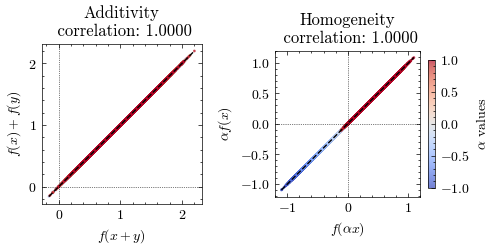

In [31]:
report.linearity_tests_analysis(model_bent, data_bent,num_samples=200)

## Test Overall

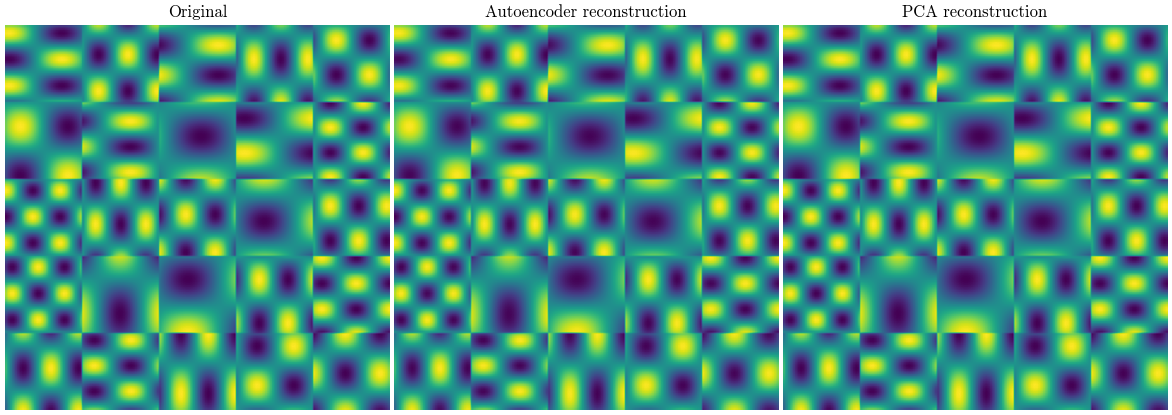

,Method,Normalized Mean Squared Error,Peak Signal-to-Noise Ratio,Structural Similarity Index
0,POLCA-Net Sinudoidal,0.0001,94.3844,1.0
1,PCA Sinudoidal,0.0000,169.8402,1.0


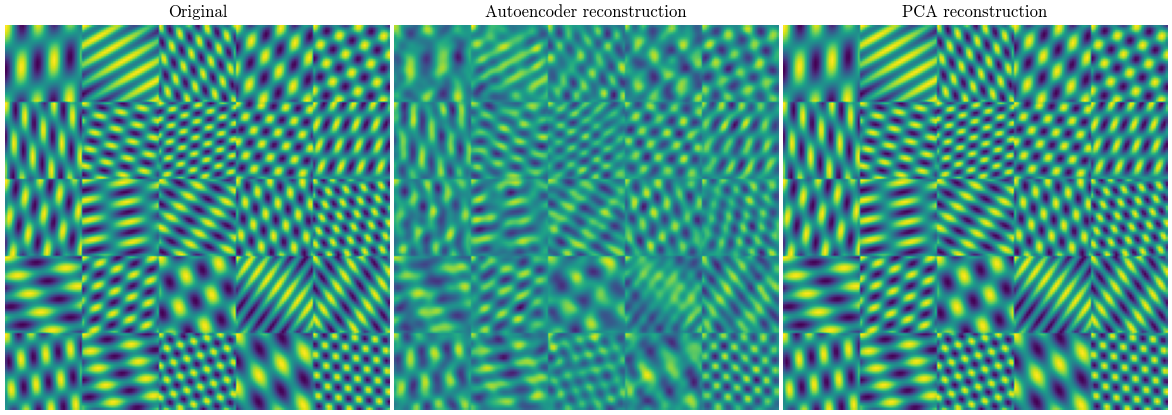

,Method,Normalized Mean Squared Error,Peak Signal-to-Noise Ratio,Structural Similarity Index
0,POLCA-Net Bent,0.0383,67.8637,0.9997
1,PCA Bent,0.0000,300.4008,1.0000


In [38]:
experiment_data = {
    "Sinudoidal" : (data_sin,model_sin,pca_sin),
    "Bent" : (data_bent,model_bent,pca_bent),
}
for k, (imgs,model,pca) in experiment_data.items():     
    images = imgs[0:25]
    
    # Reconstruct the images using the autoencoder       
    _, ae_reconstructed = model.predict(images)
    
    # Reconstruct the imagaes by PCA
    pca_latents = pca.transform(images.reshape(images.shape[0], -1))
    pca_reconstructed = pca.inverse_transform(pca_latents)
    pca_reconstructed = pca_reconstructed.reshape(images.shape[0], N, M) 

    visualise_reconstructed_images(
    [images, ae_reconstructed, pca_reconstructed],
    title_list=["Original", "Autoencoder reconstruction", "PCA reconstruction"],
)
    
    original_images = np.squeeze(images)
    reconstructed_sets = {
        f"POLCA-Net {k}": ae_reconstructed,
        f"PCA {k}": pca_reconstructed
    }
    
    metrics_table = display_metrics_table(original_images, reconstructed_sets)
    display(metrics_table)